# TSFRESH Activity Recognition on TD Data

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
# import seaborn as sns
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, EfficientFCParameters, MinimalFCParameters
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from pandas import DataFrame
import pandas as pd
import numpy as np
import os
import math

import logging

In [2]:
# We set the logger to Error level
# This is not recommend for normal use as you can oversee important Warning messages
logging.basicConfig(level=logging.ERROR)

## Data Preprocessing for tsfresh
for tsfresh指通过为了tsfresh能提取特征，需要做些格式处理。
tsfresh能接受的pandas.DataFrame有三种，这里使用了Stack DataFrame形式，格式详情可以见[Data Formats](http://tsfresh.readthedocs.io/en/latest/text/data_formats.html)
下面，首先定义一些常量和函数：

In [3]:
# 六种出行方式
travel=["bus", "car", "running", "stationary", "subway", "walking"]
# 六个传感器数据
sensor=["azimath", "pitch", "roll", "north", "east", "up"]
# 一些常量
filenum=6
sensornum=6
#窗口大小
win=50
#使用的样本数量(一个窗口的数据是一个样本)，建议设置陈6的倍数
use_num=600

In [4]:
#根据Win，生成DataFrame格式中的Time列
def getTimeColumn(win):
    time=np.arange(win)
    for idx in range(1, sensornum):
        timetmp=np.arange(win)
        time=np.concatenate((time, timetmp), axis=0)
    time.shape=(len(time),1)
    return time

#根据Win和数据，生成DataFrame格式中的kind和value列
def getKindValueColumn(sd, win):
    for i in range(sensornum):
        kind=i*np.ones((win, 1),dtype=int)
        sensorcols=sd[i]
        sensorcols.shape=(win, 1)
        sdata=np.column_stack((kind, sensorcols))
        if i==0:
            sensorframe=sdata
        else:
            sensorframe=np.row_stack((sensorframe, sdata))
    return sensorframe

def getIdColumn(num, win):
    for i in range(num):
        if i==0:
            idary=0*np.ones((sensornum*win, 1))
        else:
            idary=np.row_stack((idary, i*np.ones((sensornum*win, 1))))
    return idary

def getDataLabelColumn(dataary,label, num, win):
    for i in range(filenum):
        if i==0:
            y=label[travel[i]][:num]
            data=dataary[travel[i]][:num*win*sensornum]
        else:
            y=np.row_stack((y, label[travel[i]][:num]))
            data=np.row_stack((data, dataary[travel[i]][:num*win*sensornum]))
    y.shape=(len(y),)
    y=pd.Series(y)
    return data, y


In [5]:
#读取所有数据，结果是字典，分别存储六种运动的传感器读数矩阵，每个矩阵的三列分别是time, kind, value
def loadData(win):
    labeldict={}
    datadict={}
    files = os.listdir('/home/hadoop/data')
    for i in range(0, filenum):
        with open('/home/hadoop/data/%s' % files[i], 'r') as f:
            sensordata=np.loadtxt(f, delimiter=",")
            for j in range(0, math.ceil(len(sensordata)/win)):
                sd=sensordata[win*j:win*(j+1),:]
                sd=sd.transpose()
                
                time=getTimeColumn(win)
                kindvalue=getKindValueColumn(sd, win)
                travary=np.column_stack((time, kindvalue ))
                
                if j == 0:
                    dataarray=travary
                else:
                    dataarray=np.concatenate((dataarray, travary), axis=0)  

            labeldict[travel[i]]=i*np.ones((math.ceil(len(sensordata)/win), 1), dtype=int)
            datadict[travel[i]]=dataarray
            print(files[i]+" loaded!")
            
    return datadict, labeldict

#从所有数据dataary和其标签label中，选出总数为num的样本，每个类别选num/sensornum个样本。
def genTrainSample(dataary, label, num, win):
    idary=getIdColumn(num, win)
    labelnum=int(num/sensornum) ;
    data, y=getDataLabelColumn(dataary, label, labelnum, win)
    data=np.column_stack((idary, data))
    dataframe = DataFrame(data, columns=['id', 'time', 'kind', 'value'])
    return dataframe, y

## Load and visualize data
读取6个文件中的数据，先存在一个dict里面，然后根据tsfresh的格式要求转化陈pandas.DataFrame形式。

In [ ]:
%pdb
data, label = loadData(win)

In [7]:
print(data["bus"].shape)        #data["bus]矩阵三列分别是time, kind, value
print(label["bus"].shape)       #只有一列，因为sensornum*win条读数才是一个样本，所以label的行数是data的1/(sensornum*win)

(729900, 3)
(2433, 1)


In [8]:
#取出use_num个样本，并将data转化成tsfresh需要的pandas.DataFrame类型，存储为df；将label转化为特征过滤需要的pandas.Series类型，存储为y
df, y=genTrainSample(data, label, use_num, win)    

print(df.shape)
print(type(y))
print(y.shape)

(180000, 4)
<class 'pandas.core.series.Series'>
(600,)


In [9]:
#画出第idx个样本六个传感器的数据
def plotSample(data, kind, idx, win):
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    data=data[kind]
    for i in range(sensornum):
        plt.subplot(3,2,i+1)
        plt.title(sensor[i] + ' readings')
        begin=idx*win*sensornum + win*i
        end=begin+win-1
        plt.plot(data[begin:end, 2])
    plt.show()

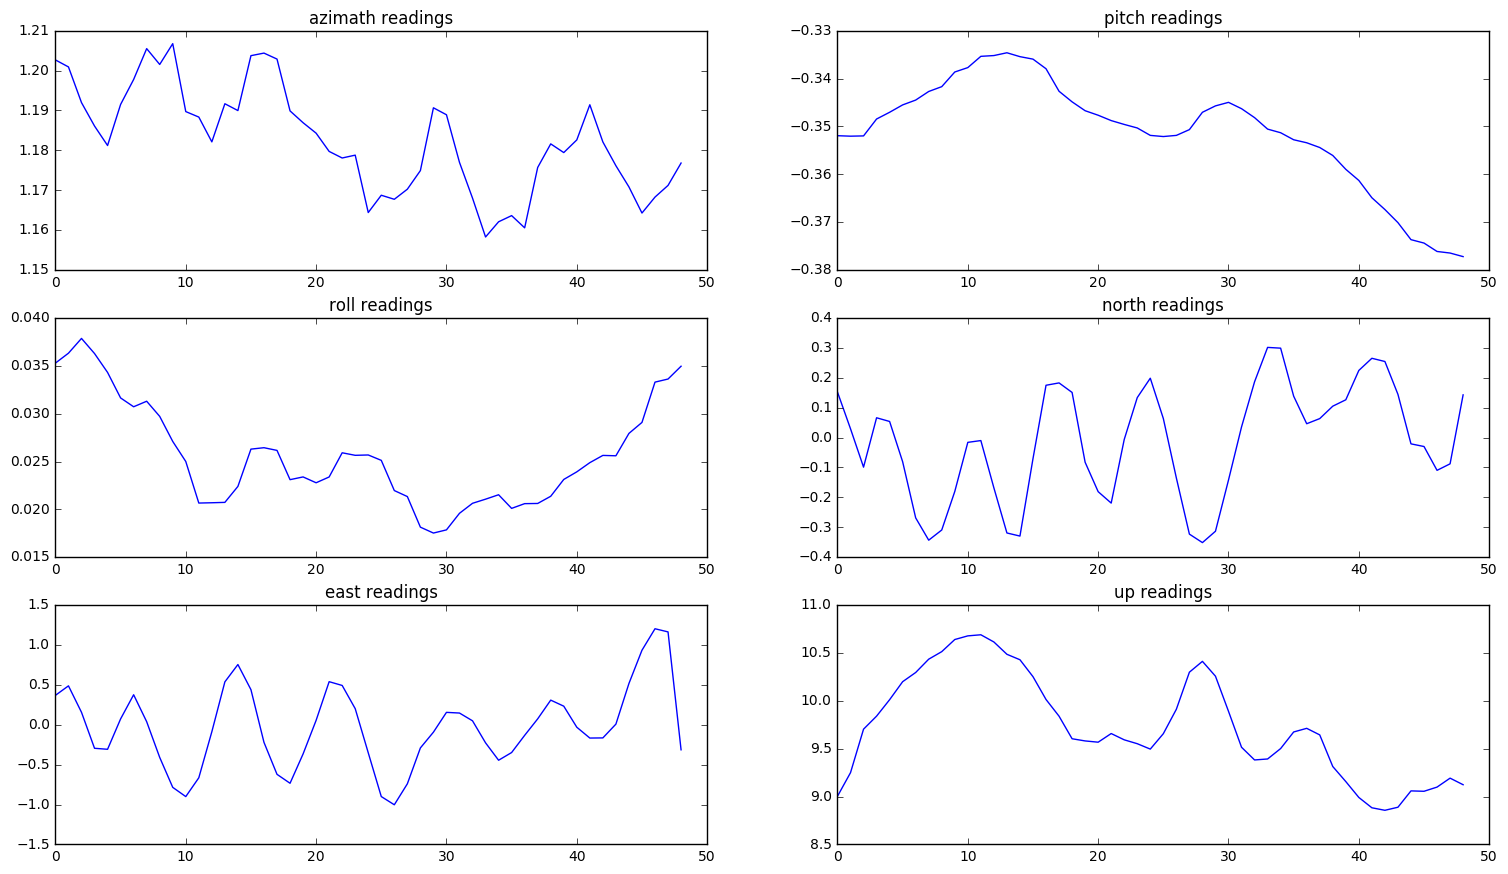

In [10]:
#展示bus数据，第idx条数据的传感器读数，注意这里的纵轴范围还没有统一，不能直接跨样本对比
kind="bus"; idx=0
plotSample(data, kind, idx, win)

## Extract Features

In [11]:
master_df = df

print(master_df.shape)
print(master_df)

(180000, 4)
           id  time  kind      value
0         0.0   0.0   0.0   1.202669
1         0.0   1.0   0.0   1.200916
2         0.0   2.0   0.0   1.191972
3         0.0   3.0   0.0   1.186100
4         0.0   4.0   0.0   1.181217
5         0.0   5.0   0.0   1.191511
6         0.0   6.0   0.0   1.197771
7         0.0   7.0   0.0   1.205506
8         0.0   8.0   0.0   1.201536
9         0.0   9.0   0.0   1.206752
10        0.0  10.0   0.0   1.189720
11        0.0  11.0   0.0   1.188346
12        0.0  12.0   0.0   1.182130
13        0.0  13.0   0.0   1.191688
14        0.0  14.0   0.0   1.189974
15        0.0  15.0   0.0   1.203741
16        0.0  16.0   0.0   1.204384
17        0.0  17.0   0.0   1.202886
18        0.0  18.0   0.0   1.189893
19        0.0  19.0   0.0   1.186932
20        0.0  20.0   0.0   1.184310
21        0.0  21.0   0.0   1.179736
22        0.0  22.0   0.0   1.178087
23        0.0  23.0   0.0   1.178802
24        0.0  24.0   0.0   1.164416
25        0.0  25.0   0.0 

In [12]:
# extraction_settings = ComprehensiveFCParameters()
extraction_settings = EfficientFCParameters()
# extraction_settings = MinimalFCParameters()

In [13]:
%time X = extract_features(master_df, default_fc_parameters=extraction_settings, column_id='id', column_sort="time", column_kind="kind", column_value="value");
# %time X = extract_features(master_df, column_id='id', column_sort="time", column_kind="kind", column_value="value");

Feature Extraction: 100%|██████████| 6/6 [04:23<00:00, 41.68s/it]

CPU times: user 168 ms, sys: 58.4 ms, total: 226 ms
Wall time: 4min 23s


In [14]:
# in total we have transformed the sensor data into 222 features
impute(X)
X.shape

(600, 1614)

In [15]:
X.columns

Index([u'1.0__mean_abs_change_quantiles__qh_0.4__ql_0.8',
       u'1.0__mean_abs_change_quantiles__qh_0.4__ql_0.2',
       u'1.0__mean_abs_change_quantiles__qh_0.4__ql_0.0',
       u'1.0__mean_abs_change_quantiles__qh_0.4__ql_0.6',
       u'1.0__mean_abs_change_quantiles__qh_0.4__ql_0.4',
                u'1.0__large_standard_deviation__r_0.15',
                         u'1.0__value_count__value_-inf',
                          u'1.0__autocorrelation__lag_6',
                       u'1.0__longest_strike_below_mean',
        u'1.0__time_reversal_asymmetry_statistic__lag_1',
       ...
                        u'4.0__fft_coefficient__coeff_0',
                        u'4.0__fft_coefficient__coeff_1',
                        u'4.0__fft_coefficient__coeff_2',
                        u'4.0__fft_coefficient__coeff_3',
                        u'4.0__fft_coefficient__coeff_4',
                        u'4.0__fft_coefficient__coeff_5',
                        u'4.0__fft_coefficient__coeff_6',
   

## Train and evaluate classifier

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [17]:
cl = DecisionTreeClassifier()
cl.fit(X_train, y_train)
print(classification_report(y_test, cl.predict(X_test)))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        17
          1       0.90      0.90      0.90        21
          2       1.00      1.00      1.00        22
          3       1.00      1.00      1.00        22
          4       0.87      0.87      0.87        15
          5       1.00      1.00      1.00        23

avg / total       0.97      0.97      0.97       120



# Multiclass feature selection

+ 若extraction_settings=EfficientFCParameters()
计算的是所有特征中计算速度较快，time cost较小的特征，考虑所有传感器序列，共得到1614个特征。
+ 若extraction_settings=MinimalFCParameters()
只计算最少的特征，共得到48个

考虑使用tsfresh的select_features来筛选，但是该函数只对二分类或者回归任务有作用。对于这个6分类问题，需要将其转化成6个二分类问题，然后对每个问题进行特征选择。

In [18]:
relevant_features = set()

for label in y.unique():
    y_train_binary = y_train == label
    X_train_filtered = select_features(X_train, y_train_binary)
    print("Number of relevant features for class {}: {}/{}".format(label, X_train_filtered.shape[1], X_train.shape[1]))
    relevant_features = relevant_features.union(set(X_train_filtered.columns))

Number of relevant features for class 0: 447/1614
Number of relevant features for class 1: 416/1614
Number of relevant features for class 2: 578/1614
Number of relevant features for class 3: 669/1614
Number of relevant features for class 4: 420/1614
Number of relevant features for class 5: 555/1614


In [19]:
len(relevant_features)

878

于是特征数量从1614降到了878

In [20]:
cl = DecisionTreeClassifier()
cl.fit(X_train, y_train)
print(classification_report(y_test, cl.predict(X_test)))

             precision    recall  f1-score   support

          0       0.89      1.00      0.94        17
          1       0.91      0.95      0.93        21
          2       0.95      0.95      0.95        22
          3       1.00      1.00      1.00        22
          4       1.00      0.80      0.89        15
          5       0.96      0.96      0.96        23

avg / total       0.95      0.95      0.95       120



测试精度也有一定降低

## Compare against naive classification accuracy

### Data Preprocessing for Native method
Native method指不提取特征，直接用所有传感器读数进行训练

In [21]:
def loadNative(win):
    labeldict={}
    datadict={}
    files = os.listdir('/home/hadoop/data')
    for i in range(0, filenum):
        with open('/home/hadoop/data/%s' % files[i], 'r') as f:
            sensordata=np.loadtxt(f, delimiter=",")
            for j in range(0, math.ceil(len(sensordata)/win)):
                sd=sensordata[win*j:win*(j+1),:]
                sd=sd.transpose()
                
                sdary=sd[0]
                for idx in range(1, sensornum):
                    sdary=np.concatenate((sdary, sd[idx]), axis=0)
                sdary.shape=(len(sdary), 1)
                if j == 0:
                    dataarray=sdary
                else:
                    dataarray=np.concatenate((dataarray, sdary), axis=1)
            
            dataarray=np.transpose(dataarray)
            labeldict[travel[i]]=i*np.ones((math.ceil(len(sensordata)/win), 1), dtype=int)
            datadict[travel[i]]=dataarray
            print(files[i]+" loaded!")
    print("Finished!") 
    return datadict, labeldict

def genNativeSample(dataary, label, num, win): 
    num=int(num/sensornum)
    for i in range(filenum):
        if i==0:
#             idary=0*np.ones((num, 1))
            y=label[travel[i]][:num]
            data=dataary[travel[i]][:num]
        else:
            y=np.row_stack((y, label[travel[i]][:num]))
            data=np.row_stack((data, dataary[travel[i]][:num]))
#             idary=np.row_stack((idary, i*np.ones((num, 1))))
#     data=np.column_stack((idary, data))
    dataframe = DataFrame(data)
    y.shape=(len(y),)
    y=pd.Series(y)
    return dataframe, y

In [22]:
data_1, label_1 = loadNative(win)

bus_data_set_101 loaded!
car_data_set_103 loaded!
running_data_set_8 loaded!
stationary_data_set_3 loaded!
subway_data_set_102 loaded!
walking_data_set_7 loaded!
Finished!


In [23]:
# print(data_1["bus"].shape)
print(data_1["bus"])

[[  1.202669   1.200916   1.191972 ...,   9.192549   9.123791   9.205205]
 [  1.174252   1.181372   1.184168 ...,   9.815362   9.744626  10.007574]
 [  1.192499   1.185541   1.197649 ...,   9.266212   9.298781   9.558616]
 ..., 
 [  0.962858   0.902889   0.902889 ...,  10.14386   10.15975   10.047433]
 [  1.078792   1.078792   1.047231 ...,   9.749497   9.74547    9.935755]
 [  1.045144   1.067814   1.0148   ...,   9.885616   9.996784  10.21252 ]]


In [24]:
X_1, y=genNativeSample(data_1, label_1, use_num, win)

In [25]:
X_1.shape

(600, 300)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=.2)

# print(X_train.head())
# print(X_test.head())
# print(y_train.head())
# print(y_test.head())

In [27]:
cl = DecisionTreeClassifier()
cl.fit(X_train, y_train)

# print(cl.predict(X_train))
# print(cl.predict(X_test))
print(classification_report(y_test, cl.predict(X_test)))

             precision    recall  f1-score   support

          0       0.94      1.00      0.97        15
          1       0.96      0.92      0.94        24
          2       0.95      0.77      0.85        26
          3       0.92      1.00      0.96        24
          4       0.72      1.00      0.84        13
          5       0.94      0.83      0.88        18

avg / total       0.92      0.91      0.91       120

